# Analyse de donnés exemplaire: Dispositif electrons

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import special
import matplotlib.pylab as plt
from __future__ import print_function, division # bring the print function and division of Python3 to 2.7

plt.style.use('seaborn-white')
plt.rcParams.update({'axes.titlesize': 24})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'xtick.labelsize' : 16})
plt.rcParams.update({'ytick.labelsize' : 16})
plt.rcParams.update({'legend.fontsize' : 16})
plt.rcParams.update({'figure.dpi': 150.})


## 1) Prerequisites

In [2]:
def gauss(x, mu, sigma, N):
    return N / np.sqrt(2*np.pi)/sigma * np.exp(-0.5*(x - mu)**2/sigma**2)

def F(x):
    return 1/2 * (1 + sp.special.erf(x/np.sqrt(2)))

def trun_gauss(x, mu, sigma, N, alpha, beta):
    return N / np.sqrt(2*np.pi)/sigma * np.exp(-0.5*(x - mu)**2/sigma**2)/(F((beta - mu)/sigma) - F((alpha - mu)/sigma))

## 2) MonteCarlo Simulation

In [3]:
# Definition of the MC truth
mu_mc = 25.0
sigma_mc = 3.2
N = 27.
xmin = mu_mc - 5*sigma_mc
xmax = mu_mc + 5*sigma_mc

# number of MC events
mc_events = 100000

# genererate MC gaussian
rnd1 = np.random.rand(mc_events)
rnd2 = np.random.rand(mc_events)
y = N*rnd1
x = xmin + (xmax - xmin)*rnd2
yprime = gauss(x, mu_mc, sigma_mc, N)

# Full gaussian:
data = x[np.where(y < yprime)]

# truncated gaussian
xmin = 22
xmax = 30
data_slice = data[(data > xmin)&(data < xmax)]


# LogLikelihood Fit of a truncated gaussian
def LogLikelihoodFit(data,mumin,mumax,mustep,sigmamin,sigmamax,sigmastep,fitrange):

    mu_grid    = np.arange(mumin, mumax, mustep)
    sigma_grid = np.arange(sigmamin, sigmamax, sigmastep)

    L = []
    for m in mu_grid:
        L_m = []
        for s in sigma_grid:
            P = trun_gauss(data, m, s, 1., fitrange[0], fitrange[1])
            L_m.append(-np.sum(np.log(P)))
        L.append(L_m)
    L = np.array(L)

    i_best = np.where(L == L.min())

    mu_best = mu_grid[i_best[0]]
    sigma_best = sigma_grid[i_best[1]]
    
    # 1D fit uncertainty
    L_sigmaBest = L[ : , i_best[1] ].flatten()
    L_muBest =  L[ i_best[0] , : ].flatten()

    mu_up = mu_grid[(L_sigmaBest > L.min()+0.5) & (mu_grid > mu_best)]
    mu_down = mu_grid[(L_sigmaBest > L.min()+0.5) & (mu_grid < mu_best)]
    
    sigma_up = sigma_grid[(L_muBest > L.min()+0.5) & (sigma_grid > sigma_best)]
    sigma_down = sigma_grid[(L_muBest > L.min()+0.5) & (sigma_grid < sigma_best)]
    
    deltaMu = (mu_up.min()- mu_down.max())/2.
    deltaSigma = (sigma_up.min()- sigma_down.max())/2.
    
    return L, mu_best[0], sigma_best[0], deltaMu, deltaSigma

mu_min = 24.
mu_max = 26.
mu_step = 0.01

sigma_min = 2.5
sigma_max = 4.0
sigma_step = 0.001

mu_grid    = np.arange(mu_min, mu_max, mu_step)
sigma_grid = np.arange(sigma_min, sigma_max, sigma_step)
    
L_mc, mu_best_mc, sigma_best_mc, dMu_mc, dSigma_mc = LogLikelihoodFit(data_slice,mu_min,mu_max,mu_step,sigma_min,sigma_max,sigma_step,[xmin,xmax])

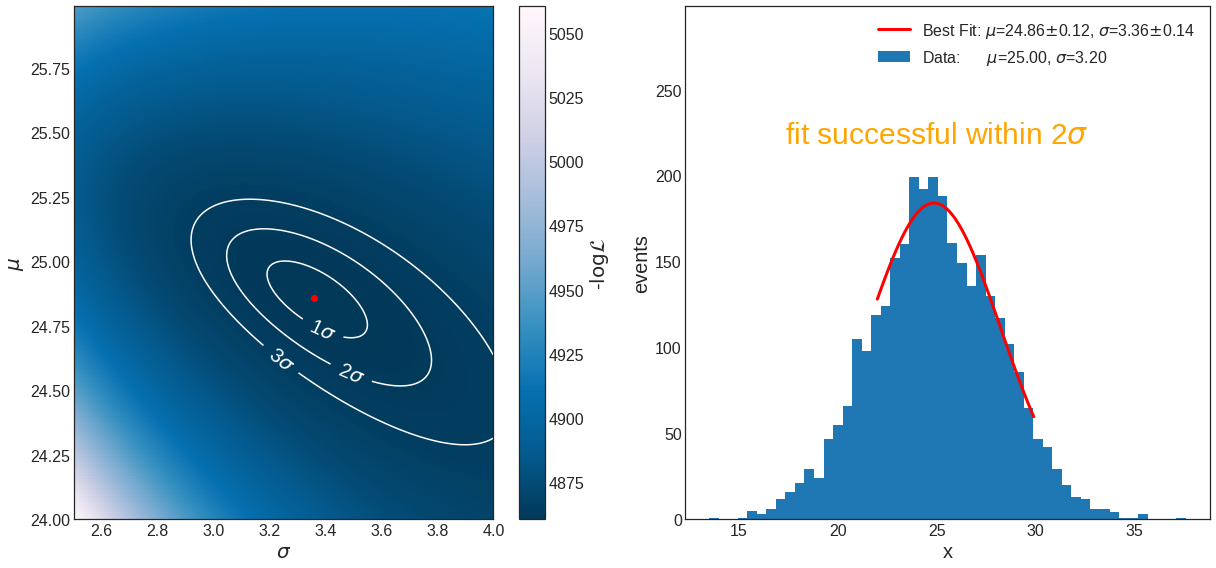

In [4]:
# plot
fig, axs = plt.subplots(1,2, figsize=(17,8))

mesh = axs[0].pcolormesh(sigma_grid, mu_grid, L_mc, cmap='PuBu_r')
cs = axs[0].contour(sigma_grid, mu_grid, L_mc, [L_mc.min() + 0.5, L_mc.min() + 4./2., L_mc.min() + 9./2.],colors='white')
fmt = {}
strs = ['1$\sigma$', '2$\sigma$', '3$\sigma$']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
cbar = fig.colorbar(mesh, ax = axs[0])
cbar.ax.set_ylabel('-$\log \mathcal{L}$')
axs[0].clabel(cs, cs.levels, inline=1, fmt=fmt, fontsize=20)
axs[0].plot(sigma_best_mc, mu_best_mc, marker='o',color='r')
axs[0].set_xlabel('$\sigma$')
axs[0].set_ylabel('$\mu$')


h,bins, _ = axs[1].hist(data,bins = 50,density=False, label="Data:      $\mu$={:.2f}, $\sigma$={:.2f}".format(mu_mc,sigma_mc))
x = np.arange(xmin, xmax, 0.1)
binwidth = np.diff(bins)[0]
axs[1].plot(x, trun_gauss(x, mu_best_mc, sigma_best_mc, 1.*len(data_slice)*binwidth , xmin, xmax), lw =3 , color ='r', label="Best Fit: $\mu$={:.2f}$\pm${:.2f}, $\sigma$={:.2f}$\pm${:.2f}".format(mu_best_mc,dMu_mc,sigma_best_mc,dSigma_mc))
axs[1].set_xlabel("x")
axs[1].set_ylabel("events")
axs[1].set_ylim(0,1.5*h.max())
axs[1].legend(loc="upper right")

if np.abs(mu_best_mc-mu_mc) < dMu_mc and np.abs(sigma_best_mc-sigma_mc) < dSigma_mc:
    text = 'fit successful within 1$\sigma$'
    color = 'green'
elif np.abs(mu_best_mc-mu_mc) < 2*dMu_mc and np.abs(sigma_best_mc-sigma_mc) < 2*dSigma_mc:
    text = 'fit successful within 2$\sigma$'
    color = 'orange'
else:
    text = 'fit not successful'
    color = 'red'
    
axs[1].annotate(text, xy=(25, 1.1*h.max()),color=color, fontsize=30 , ha='center')
plt.tight_layout()

## 3) Data

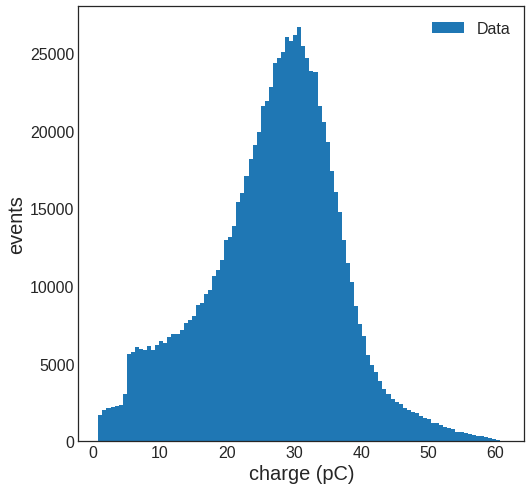

In [5]:
Exp_data = np.loadtxt('exampleData/2019_electronSetup.txt')
Exp_data = Exp_data*0.015

fig, ax = plt.subplots(1,1, figsize=(8,8))
h,bins, _ = ax.hist(Exp_data,bins = 100,density=False, label="Data")
ax.set_xlabel("charge (pC)")
ax.set_ylabel("events")
ax.legend(loc="upper right")

In [6]:
fit_truncation = [25,40]
Exp_data_slice = Exp_data[(Exp_data>fit_truncation[0]) & (Exp_data<fit_truncation[1])]

mu_min = 25.
mu_max = 32.
mu_step = .1

sigma_min = 5
sigma_max = 10.
sigma_step = 0.1

mu_grid    = np.arange(mu_min, mu_max, mu_step)
sigma_grid = np.arange(sigma_min, sigma_max, sigma_step)

L, mu_best, sigma_best, dMu, dSigma = LogLikelihoodFit(Exp_data_slice,mu_min,mu_max,mu_step,sigma_min,sigma_max,sigma_step,fit_truncation)


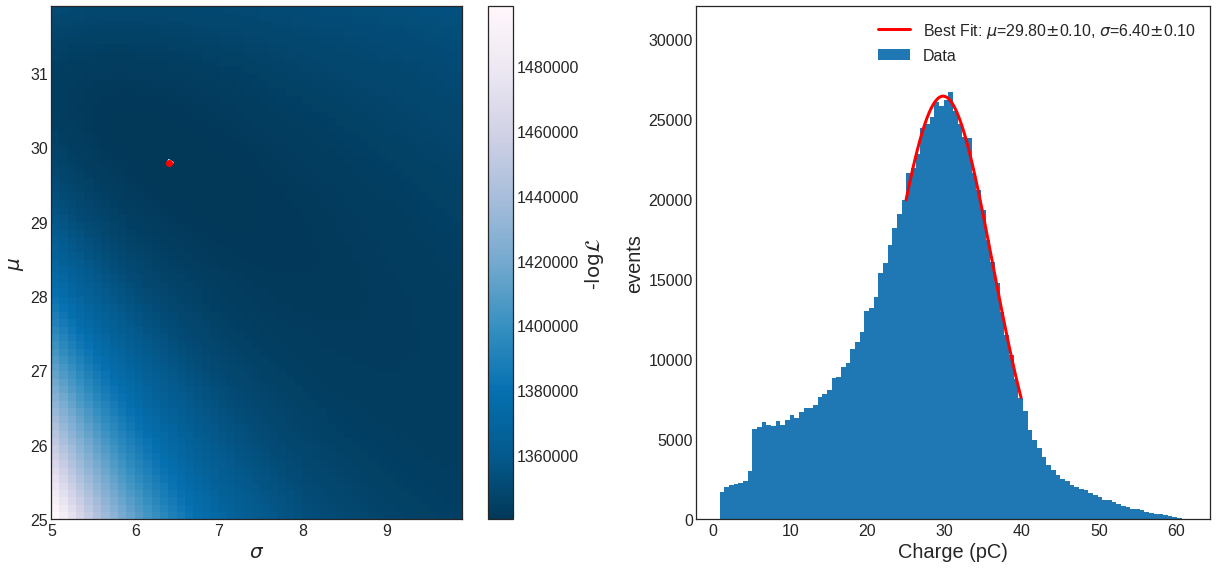

In [7]:
# plot
fig, axs = plt.subplots(1,2, figsize=(17,8))

mesh = axs[0].pcolormesh(sigma_grid, mu_grid, L, cmap='PuBu_r')
cs = axs[0].contour(sigma_grid, mu_grid, L, [L.min() + 0.5, L.min() + 4./2., L.min() + 9./2.],colors='white')
fmt = {}
strs = ['1$\sigma$', '2$\sigma$', '3$\sigma$']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
cbar = fig.colorbar(mesh, ax = axs[0])
cbar.ax.set_ylabel('-$\log \mathcal{L}$')
axs[0].clabel(cs, cs.levels, inline=1, fmt=fmt, fontsize=20)
axs[0].plot(sigma_best, mu_best, marker='o',color='r')
axs[0].set_xlabel('$\sigma$')
axs[0].set_ylabel('$\mu$')


h,bins, _ = axs[1].hist(Exp_data,bins = 100,density=False, label="Data")
x = np.arange(fit_truncation[0], fit_truncation[1], 0.1)
binwidth = np.diff(bins)[0]
axs[1].plot(x, trun_gauss(x, mu_best, sigma_best, 1.*len(Exp_data_slice)*binwidth , fit_truncation[0], fit_truncation[1]), lw =3 , color ='r', label="Best Fit: $\mu$={:.2f}$\pm${:.2f}, $\sigma$={:.2f}$\pm${:.2f}".format(mu_best,dMu,sigma_best,dSigma))
axs[1].set_xlabel("Charge (pC)")
axs[1].set_ylabel("events")
axs[1].set_ylim(0,1.2*h.max())
axs[1].legend(loc="upper right")

plt.tight_layout()